In [1]:
from src.utils import download_images

In [2]:
import pandas as pd
df = pd.read_csv('train.csv')

In [3]:
df_10 = df.sample(10)
df_10

,image_link,group_id,entity_name,entity_value
6235,https://m.media-amazon.com/images/I/71o+p-lv51...,529606,item_weight,9.0 ounce
43917,https://m.media-amazon.com/images/I/619F3n8qDd...,630390,item_weight,2.0 pound
130222,https://m.media-amazon.com/images/I/518QGspQN1...,892291,wattage,13.0 watt
40869,https://m.media-amazon.com/images/I/71zxCLlnK3...,929999,item_weight,9 gram
103668,https://m.media-amazon.com/images/I/81FT7FlEXh...,179080,voltage,48.0 volt
4681,https://m.media-amazon.com/images/I/71lVOX3rIF...,767202,item_weight,47.0 gram
115300,https://m.media-amazon.com/images/I/71e3ZRrXy6...,483370,item_weight,6.94 pound
236039,https://m.media-amazon.com/images/I/51RsUsW+uX...,442321,height,90.17 centimetre
47460,https://m.media-amazon.com/images/I/71NQkLDAvm...,179080,item_weight,21.5 pound
219060,https://m.media-amazon.com/images/I/51wt3cMYYk...,695925,depth,32.0 centimetre


In [4]:
images_links = df_10['image_link'].to_list()

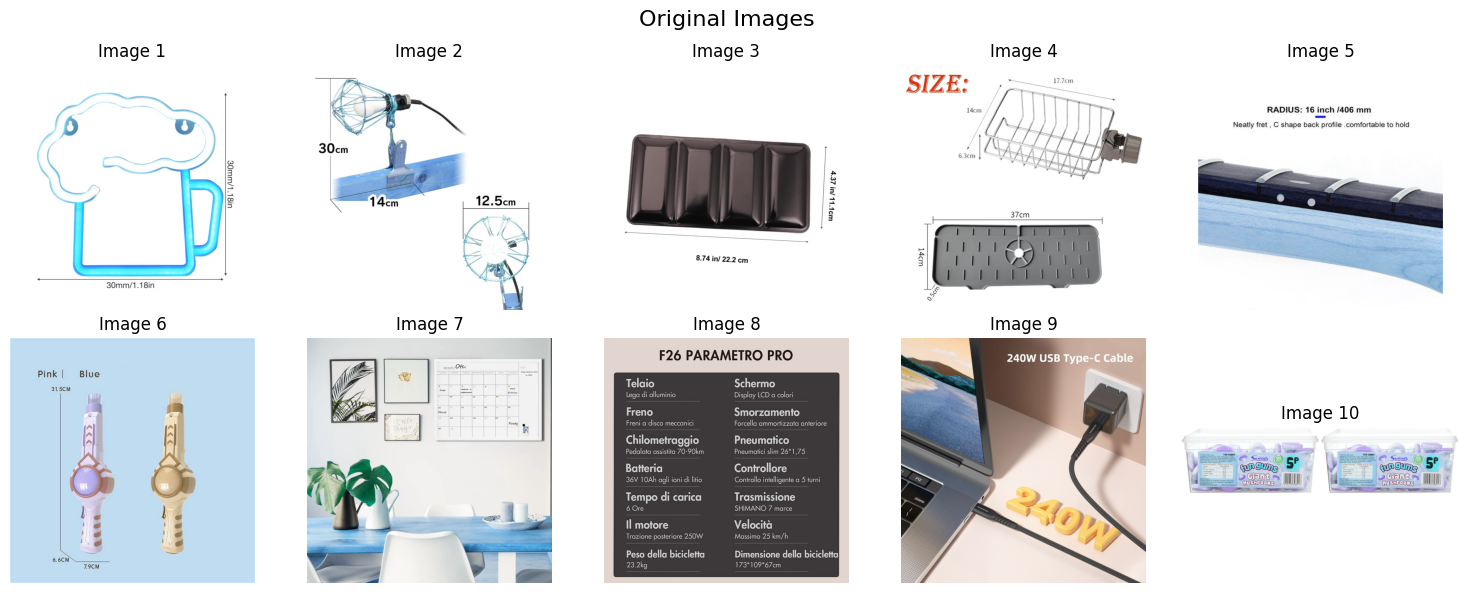

In [8]:
import cv2
import pytesseract
import numpy as np
import os
import matplotlib.pyplot as plt

# Function to display multiple images in a grid
def display_images(images, title):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows, 5 columns
    fig.suptitle(title, fontsize=16)
    
    for i, img in enumerate(images):
        ax = axes[i // 5, i % 5]
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        ax.set_title(f'Image {i+1}')
    
    plt.tight_layout()
    plt.show()

# Initialize an array to store the images
image_paths = [os.path.join('sample_images', filename) for filename in os.listdir('sample_images') if filename.endswith(('.png', '.jpg', '.jpeg'))]

original_images = [cv2.imread(path) for path in image_paths if cv2.imread(path) is not None]

display_images(original_images, "Original Images")


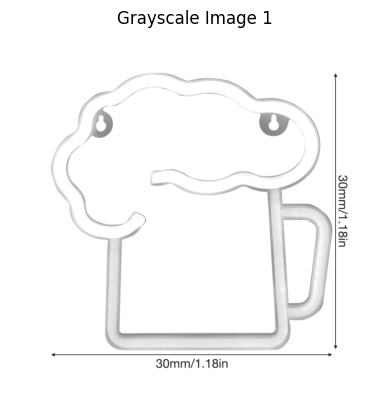

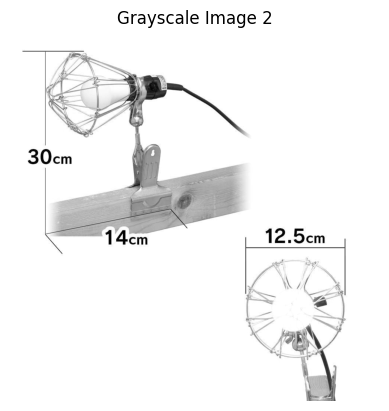

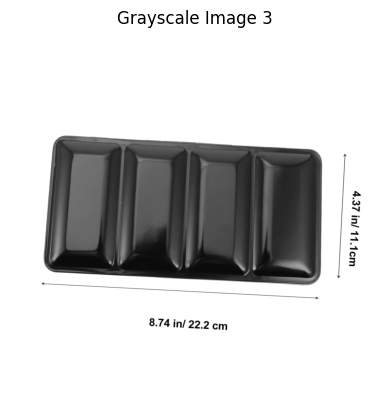

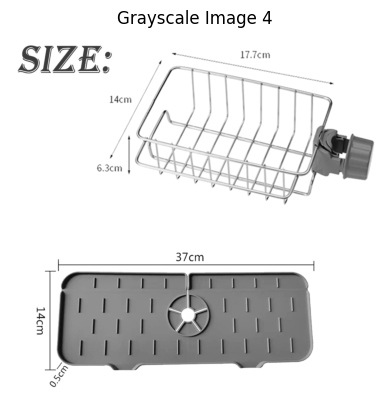

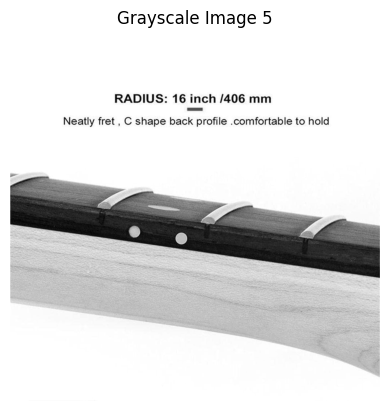

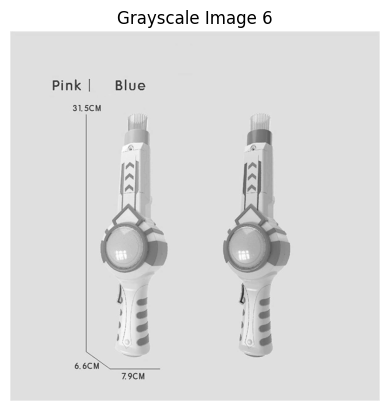

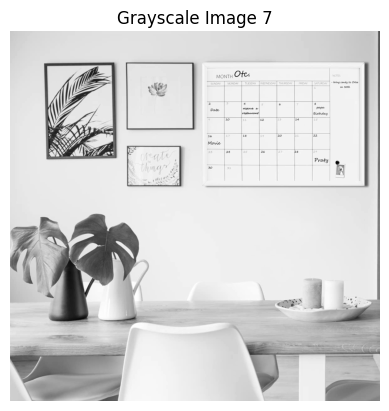

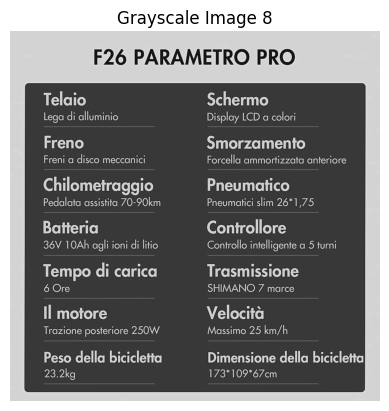

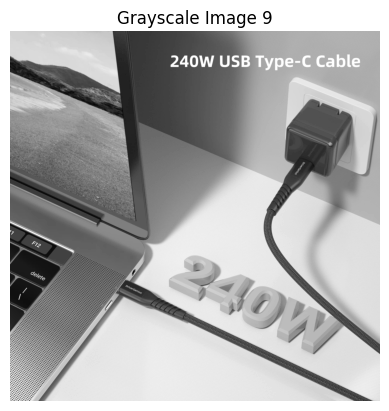

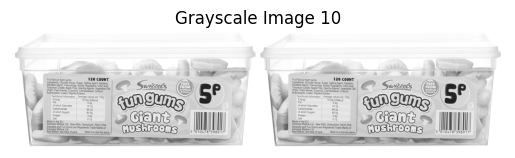

In [29]:
# Grayscale conversion
gray_images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in original_images]

# Display each grayscale image individually
for i, gray_img in enumerate(gray_images):
    plt.imshow(gray_img, cmap='gray')
    plt.title(f'Grayscale Image {i+1}')
    plt.axis('off')
    plt.show()


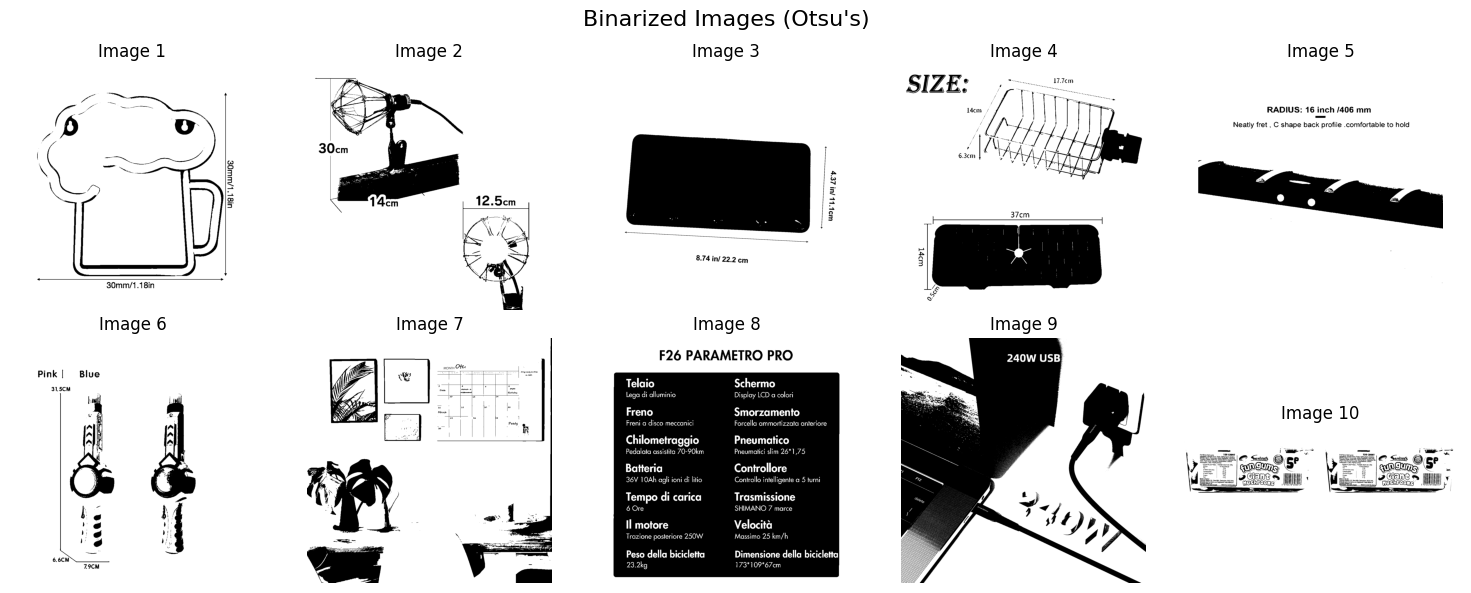

In [30]:
# Apply Otsu's binarization
binary_images = [cv2.threshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1] for img in original_images]
display_images(binary_images, "Binarized Images (Otsu's)")

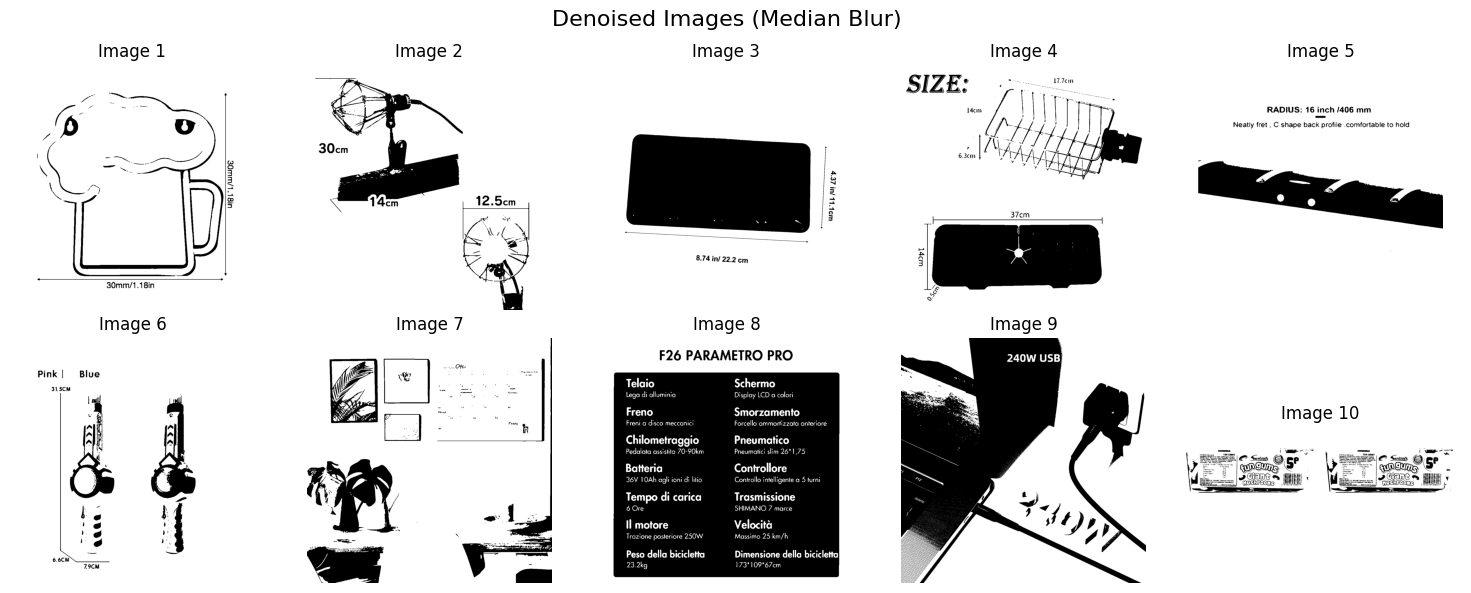

In [31]:
# 4. Noise removal using Median Blur and display
denoised_images = [cv2.medianBlur(binary, 3) for binary in binary_images]
display_images(denoised_images, "Denoised Images (Median Blur)")

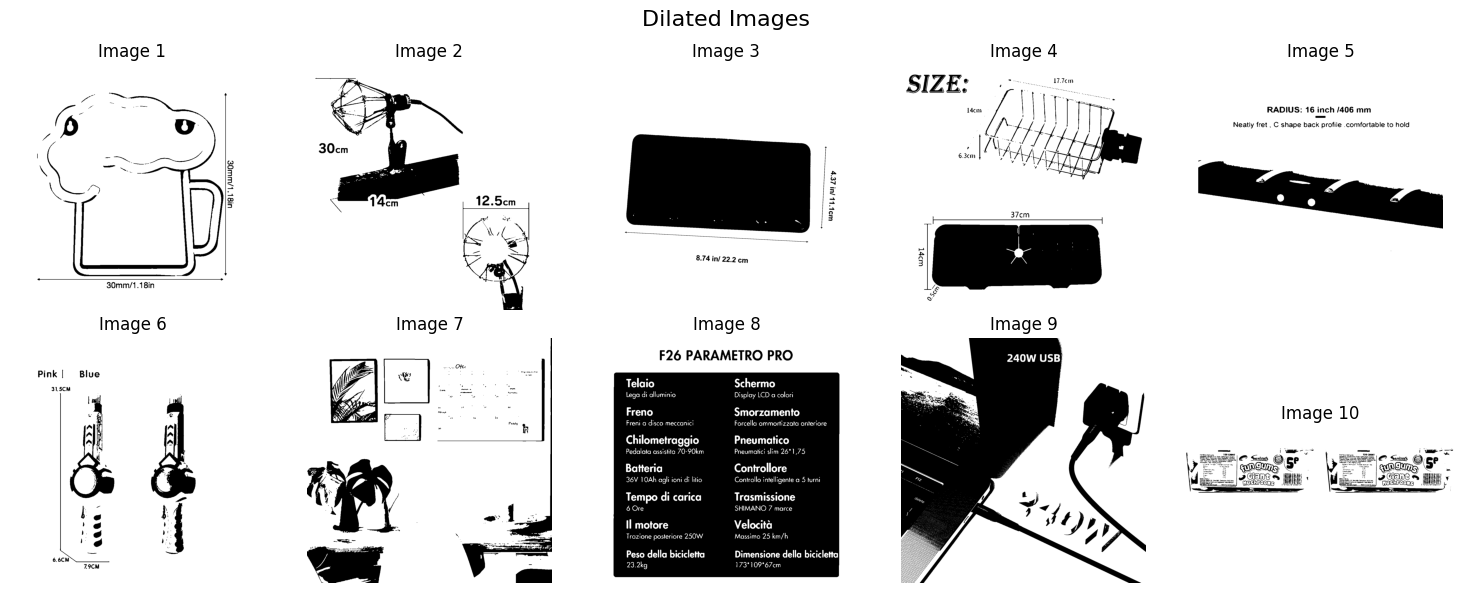

In [32]:
# 5. Dilation and display
kernel = np.ones((1, 1), np.uint8)
dilated_images = [cv2.dilate(denoised, kernel, iterations=1) for denoised in denoised_images]
display_images(dilated_images, "Dilated Images")

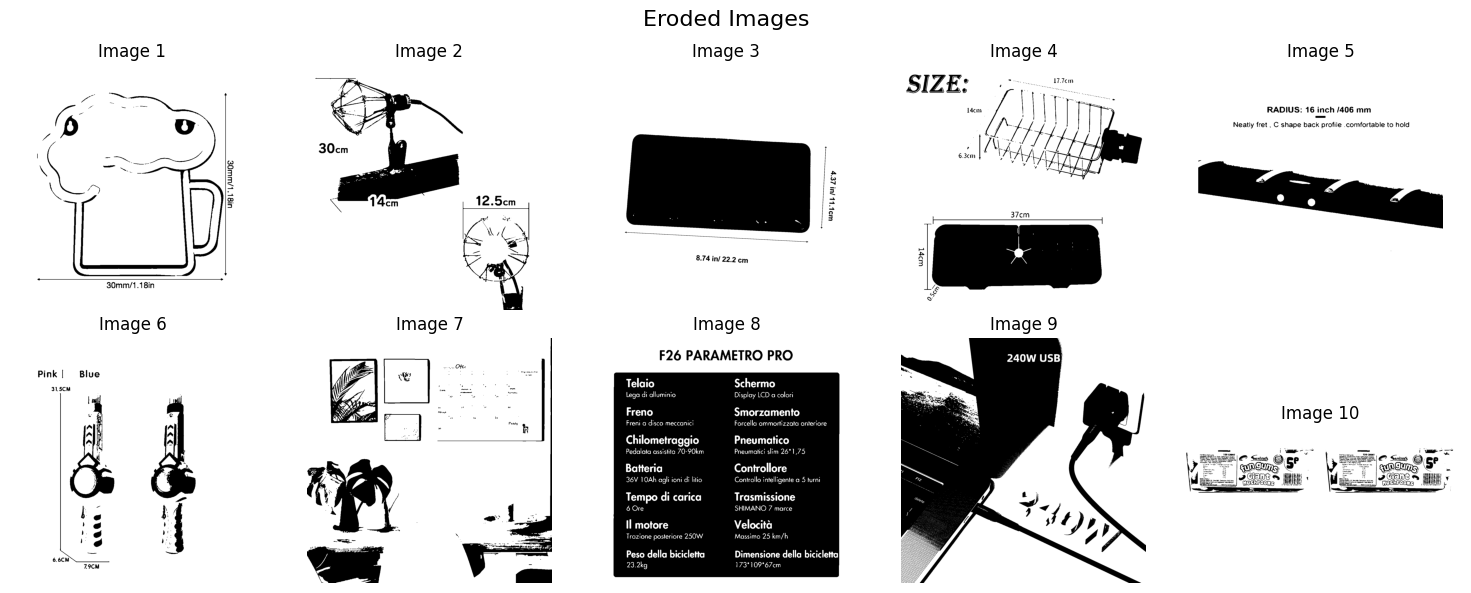

In [33]:
# 6. Erosion and display
eroded_images = [cv2.erode(dilated, kernel, iterations=1) for dilated in dilated_images]
display_images(eroded_images, "Eroded Images")


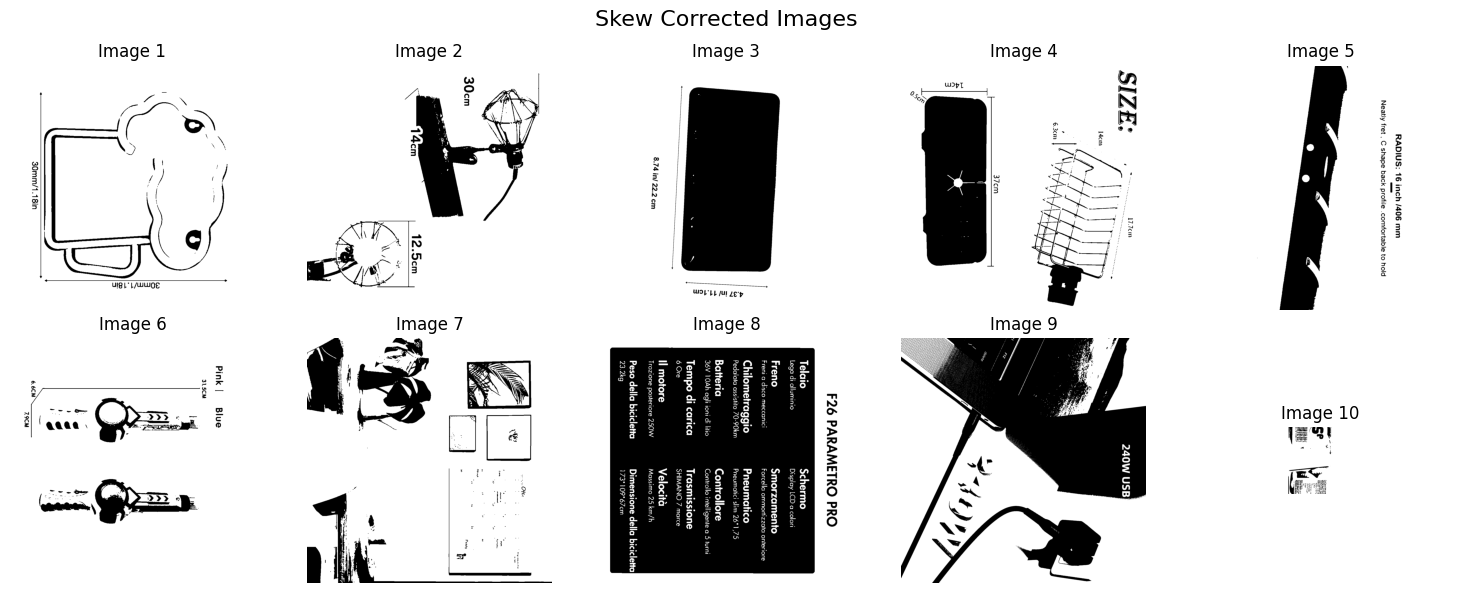

In [34]:
# 7. Skew Correction (rotation) and display
def correct_skew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated
skew_corrected_images = [correct_skew(eroded) for eroded in eroded_images]
display_images(skew_corrected_images, "Skew Corrected Images")

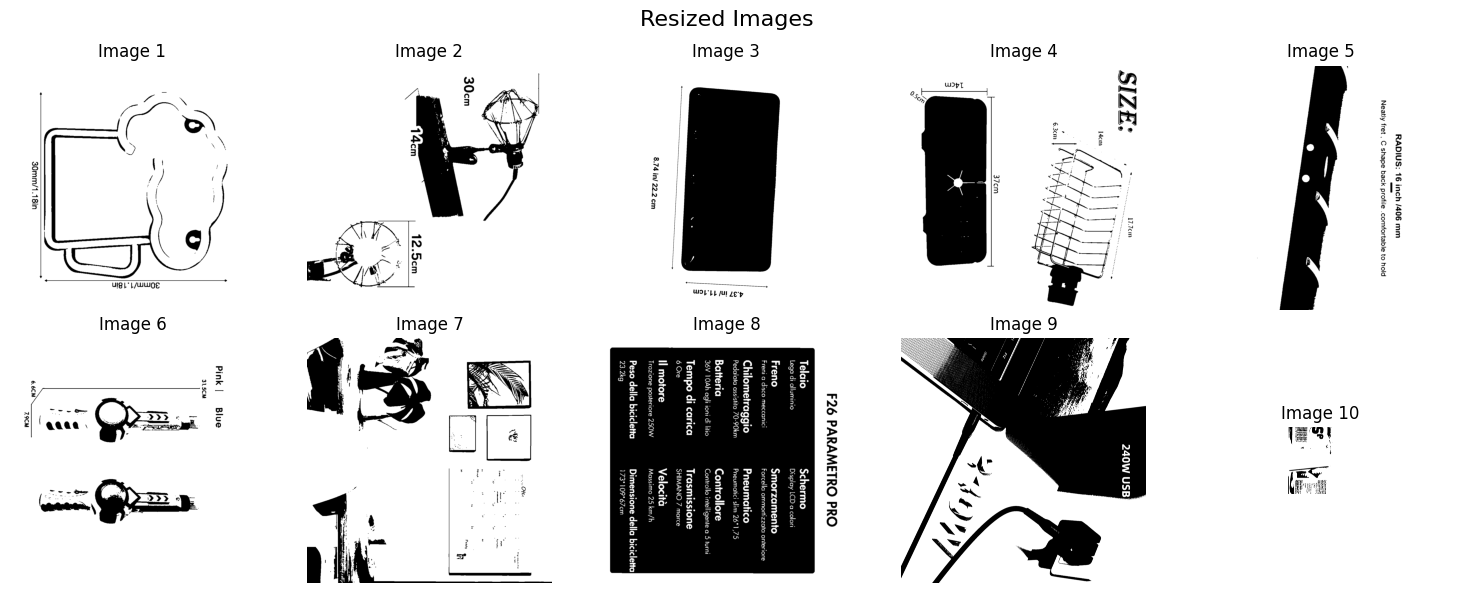

In [35]:
# 8. Resize images (increase size for better OCR performance)
resized_images = [cv2.resize(image, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC) for image in skew_corrected_images]
display_images(resized_images, "Resized Images")

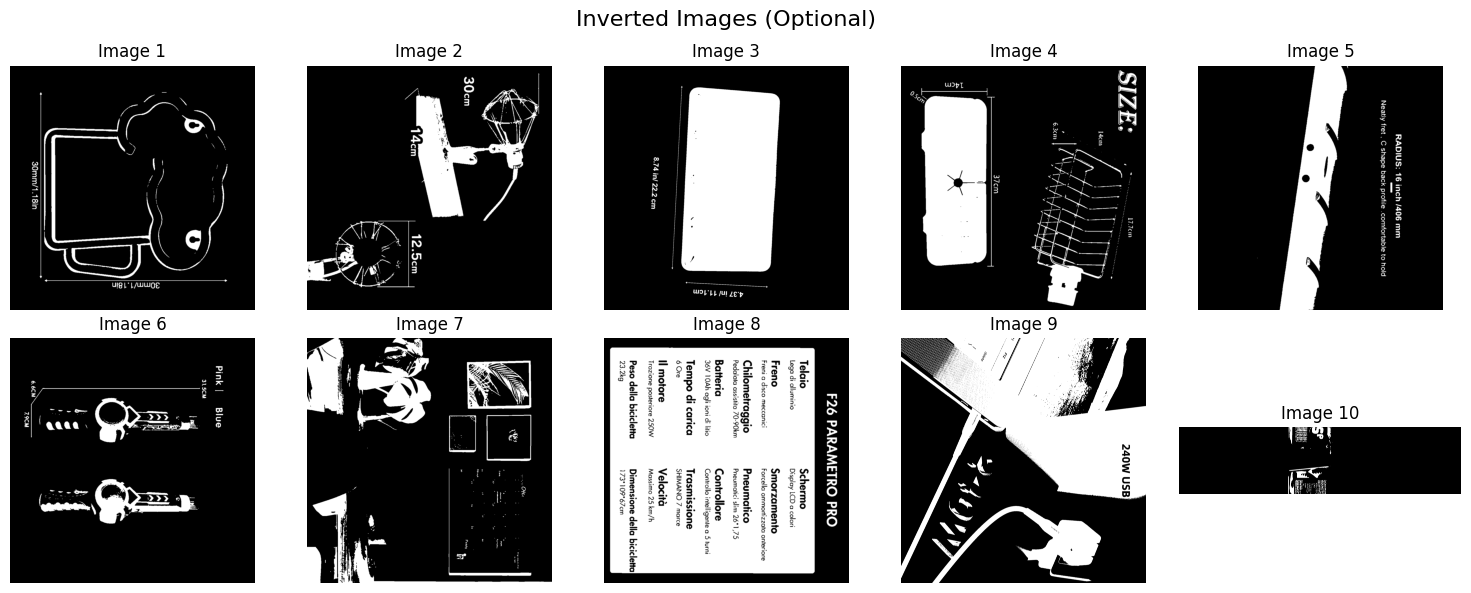

In [36]:
# 9. Invert colors for white text on black background (optional, based on image content)
inverted_images = [cv2.bitwise_not(image) for image in resized_images]
display_images(inverted_images, "Inverted Images (Optional)")

In [37]:
# 10. OCR Processing on each preprocessed image
ocr_results = []
for img in inverted_images:
    text = pytesseract.image_to_string(img)
    ocr_results.append(text)

In [38]:
# Output OCR results for each image
for idx, text in enumerate(ocr_results):
    print(f"Text from image {idx+1}:\n{text}\n")

Text from image 1:
U8 | /WILUOE

UI | * | /WULUOE


Text from image 2:


Text from image 3:
8.74 in/ 22.2 cm

WILLE (Ul 2E"p


Text from image 4:
KZ.

6% mM

WPT



Text from image 5:
RADIUS: 16 inch /406 mm

Neatly fret , C shape back profile .comfortable to hold



Text from image 6:
W262

WOS LE

| 4uld

ania


Text from image 7:


Text from image 8:
F26 PARAMETRO PRO

Telaio

Lega di alluminio

Freno

Freni o disco meccanici

Chilometraggio
Pedalaia assistita 70-90km

Batteria
36V 10Ah agli ioni di litio

Tempo di carica
6 Ore

Il motore
Trazione posteriore 250W

Peso della bicicletta
23.2kg

Schermo
Display LCD a colori

Smorzamento

Forcella ammortizzata anteriore

Pneumatico
Pneumatici slim 26°1,75

Controllore

Controllo intelligente a 5 turni

Trasmissione
SHIMANO 7 marce

Velocita
Massimo 25 km/h

Dimensione della bicicletta
173°109°67cm



Text from image 9:
240W USB;



Text from image 10:
cP
T ute

Mu 398917



